In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Calibration Procedure

<i>this version uses `calibration_sweep.h5` files and indexes of specified calibration lines automatically. i.e. table 2 bellow is generated automatically. </i>


* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |




# How to use this version:

    0) define equipment parameters.

for each grating:

    1) specify 'd_grating' and compute center offset as discriped above (--> `n0`).

    2) take a `calibration_sweep`. Make sure the known peaks are well included in the sweep. 
    
    3) define 'calibration_lines_wls' list.

    4) Verify that the algorithm detects the peaks. 

# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $n_o$: effective central pixels (averaged over a couple measurement)
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



# calibration with Hg/Ar lamp
Hg has strong persistent line at 194.223, 435.8328, 912.288, 1529.582nm. The last two are perticularly useful for NIR https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable2.htm

In [6]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

import h5py
import peakutils
from peakutils.plot import plot as pplot

%matplotlib inline

In [7]:
from scipy.optimize import least_squares


def wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma, curvature):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - (n0+offset_adjust*wl_center)

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta))) + curvature*n**2


def fit_residual(
                # optimization parameters
                opt_params, #  (f, delta, gamma, curvature)
                # other params and data
                px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, 
                wl_actual
                ):
    
    (f, delta, gamma, curvature) = opt_params
    wl_model = wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma,curvature)
    return (wl_model - wl_actual)


def argmin(ar,v):
    return np.argmin( (ar - v)**2)

def arange_like(ar):
    return np.arange(len(ar))

def clean_repetitions(LIST):
    to_del = []
    for i,element in enumerate(LIST):
        a = LIST[i]
        b = LIST[i-1]
        if a[0] == b[0] and a[-1] == b[-1]:
            to_del.append(i-1)
    for index in sorted(to_del, reverse=True):
        del LIST[index]
    return LIST


def get_dispersion_data_forward(ii, n_peak, wl_actual, wl_centers, peak_indexes, dispersion_data):
    '''
    recursivly builds up the dispersion data INcreasing ii
    
    ii           index of spectra
    n_peak       pixel index 
    wl_actual    wavelength of the calibration line to be calibrated
    wl_centers   list of all center wavelengths 
    peak_indexes list of list with indexes of peaks
    '''
    if ii+1 < len(peak_indexes):
        neighbour_peaks = peak_indexes[ii+1]
        nearest_neighbour_peak = neighbour_peaks[ argmin(neighbour_peaks, n_peak) ]
        
        if nearest_neighbour_peak > dispersion_data[-1][-1]: #the next closet data point is not on the left
            return dispersion_data
        else:
            dispersion_data.append([wl_actual, wl_centers[ii+1], nearest_neighbour_peak])
            dispersion_data = get_dispersion_data_forward(ii+1, nearest_neighbour_peak, 
                              wl_actual, wl_centers,
                              peak_indexes, dispersion_data)
    return dispersion_data
    
    
def get_dispersion_data_backward(ii, n_peak, wl_actual, wl_centers, peak_indexes, dispersion_data):
    '''
    recursivly builds up the dispersion data Decreasing ii
    
    ii           index of spectra
    n_peak       pixel index 
    wl_actual    wavelength of the calibration line to be calibrated
    wl_centers   list of all center wavelengths 
    peak_indexes list of list with indexes of peaks
    '''
    if ii-1 > 0:
        neighbour_peaks = peak_indexes[ii-1]
        nearest_neighbour_peak = neighbour_peaks[ argmin(neighbour_peaks, n_peak) ]
        if nearest_neighbour_peak < dispersion_data[-1][-1]: #the next closet data point is not on the right
            return dispersion_data
        dispersion_data.append([wl_actual, wl_centers[ii-1], nearest_neighbour_peak])
        dispersion_data = get_dispersion_data_backward(ii-1, nearest_neighbour_peak, 
                          wl_actual, wl_centers,
                          peak_indexes, dispersion_data)
    return dispersion_data

### 0) specify equipment parameters.


In [8]:
x_pixel = 25e3 #nm pixel_width
f = 300e6
offset_adjust = 0

In [9]:


 
    #[fname, d_grating, px_offsets_data]
input_params = [['grating_1_data/190116_174423_calibration_sweep.h5',   ],
                ]

# grating (1, '600 g/mm BLZ=  1.0UM ')

In [17]:
###################################### INPUTS HERE ##########
fname  = 'grating_1_data/190116_174423_calibration_sweep.h5'
d_grating = 1e6/600 #nm/groove
px_offsets_data = [467,466]

calibration_lines_wls = [912.288, 
                         965.770, 
                         1013.975,
                         1128.71,
                         1529.582
                        ] #nm

In [18]:
n0 = np.mean(px_offsets_data)
calibration_lines_wls = sorted(calibration_lines_wls)

### dispersion data

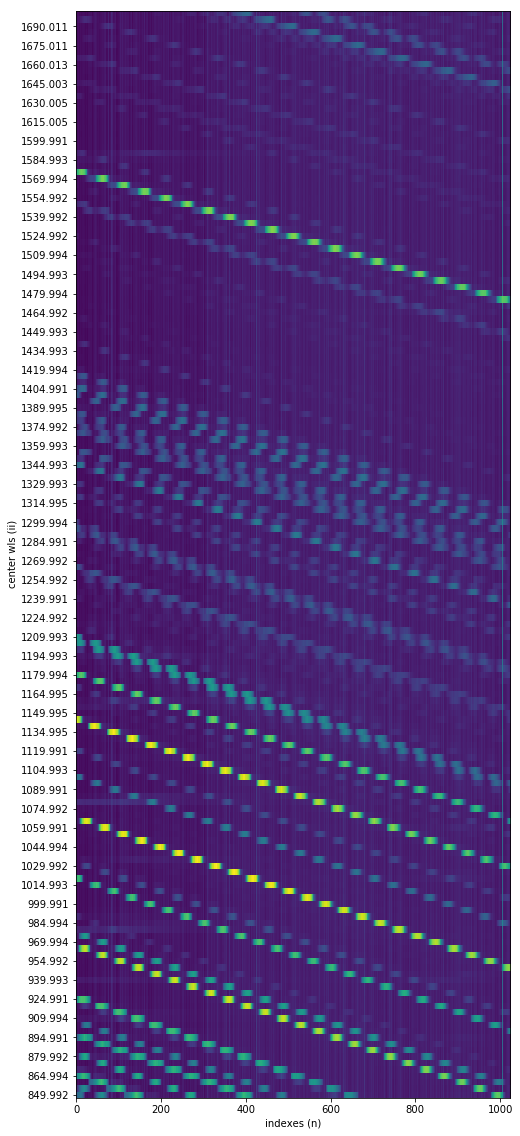

In [19]:
h5_file=h5py.File(fname)
center_wls=h5_file['measurement/calibration_sweep/center_wls'].value
spectra=h5_file['measurement/calibration_sweep/spectra'].value
h5_file.close()

plt.figure(figsize=(20,20))
plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(15)
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')
plt.yticks(arange_like(center_wls)[::3],center_wls[::3]);

### find peaks and identify calibration peaks based on center wls

[[12, [[912.288, 909.99400000000003, 488]]], [23, [[965.77, 964.99099999999999, 475]]], [33, [[1013.975, 1014.9930000000001, 460]]], [56, [[1128.71, 1129.9939999999999, 457]]], [136, [[1529.582, 1529.9939999999999, 462]]]]


(0, 1024)

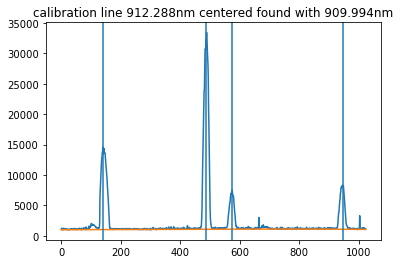

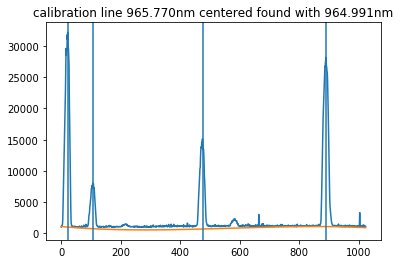

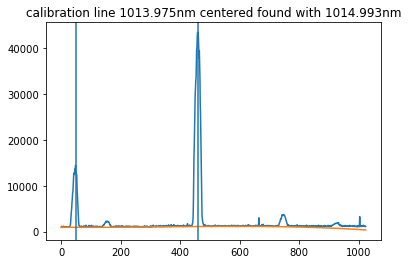

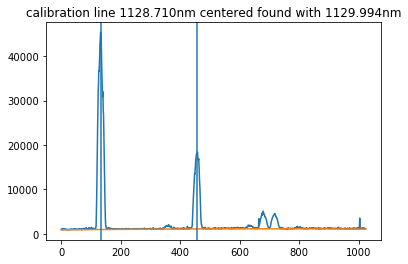

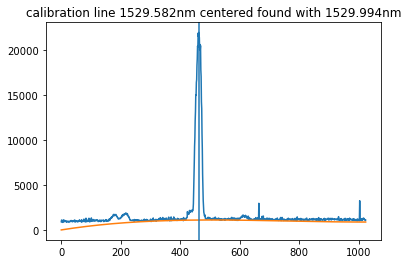

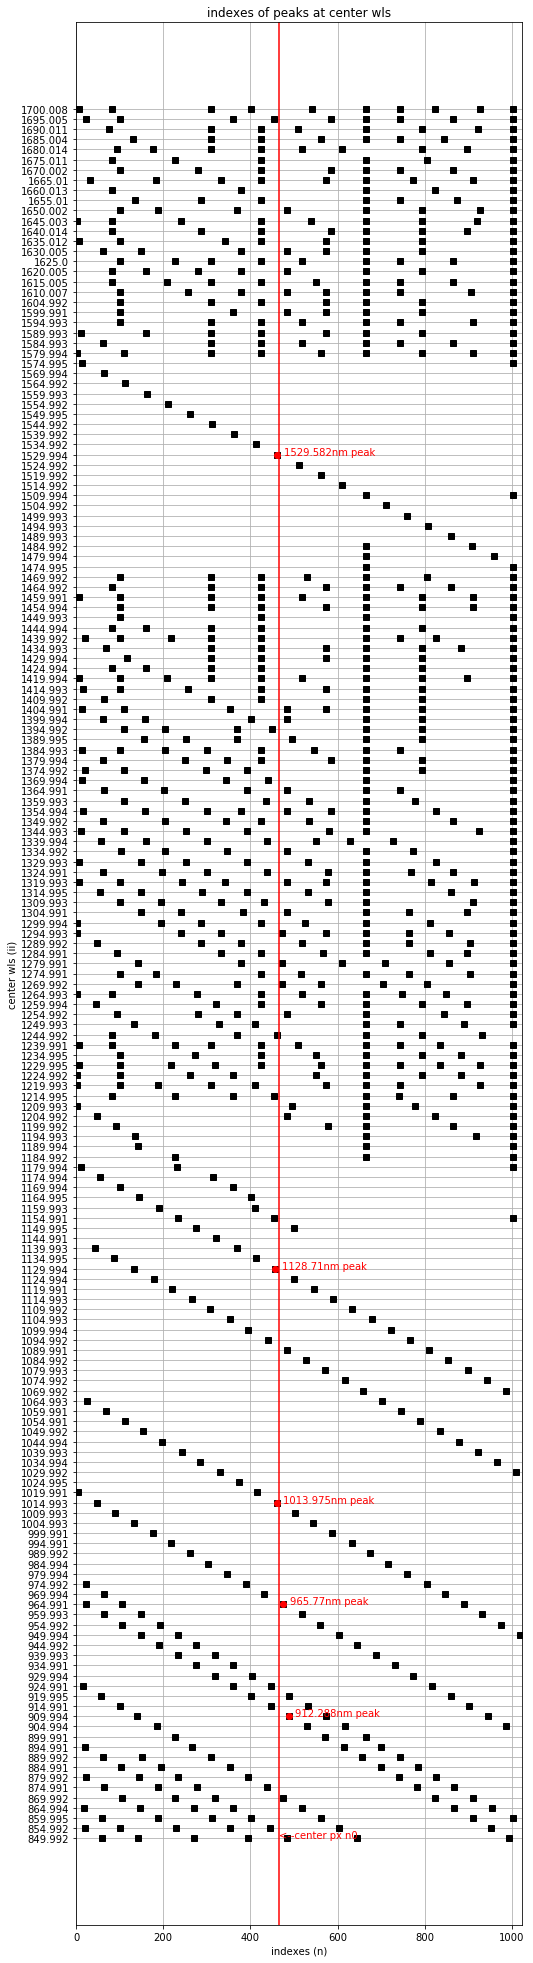

In [20]:
# find spectrum center wls is closest to calibration lines
ii_peak_identifyers = np.array([argmin(center_wls, wls) for wls in calibration_lines_wls])

plot_spectra = True
peak_indexes = []

jj = 0 
dispersion_initial_data_points = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 3)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
        
    if plot_spectra and ii in ii_peak_identifyers:
        calibration_line = calibration_lines_wls[jj]
        center_wl = center_wls[ii]
        plt.figure()
        plt.title('calibration line {:1.3f}nm centered found with {:1.3f}nm'.format(calibration_line, center_wl ) )
        
        n_peak = indexes[ argmin(indexes, n0) ]

        disp = [[calibration_line, center_wls[ii], n_peak]]
        dispersion_initial_data_points.append([ii, disp])
        
        jj += 1
                
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure(figsize=(8,35))
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
plt.title('indexes of peaks at center wls')
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')

plt.grid(True, which='both', ydata = arange_like(center_wls))

plt.yticks(arange_like(center_wls)[::1],center_wls[::1])

for k,(ii,dispersion_data) in enumerate(dispersion_initial_data_points):
    n_peak = dispersion_data[0][-1]
    plt.plot(n_peak,ii, 'or')
    plt.text(n_peak+15,ii, '{}nm peak'.format(calibration_lines_wls[k]), color='r')
    
print(dispersion_initial_data_points)

plt.axvline(n0, color='r')
plt.text(n0, 0, '<--center px n0', color='r')

plt.xlim(0,1024)
#plt.ylim(0,136)

### track individual peaks and associate with actual wavelengths

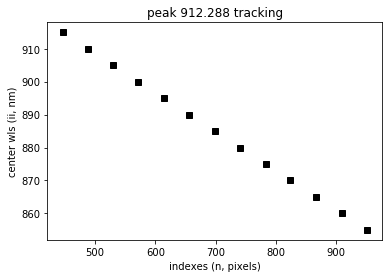

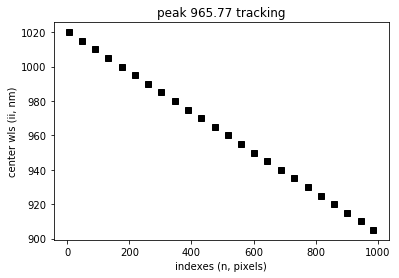

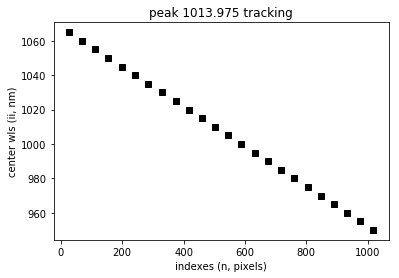

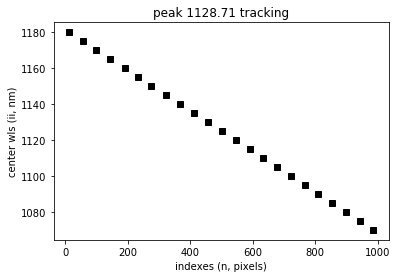

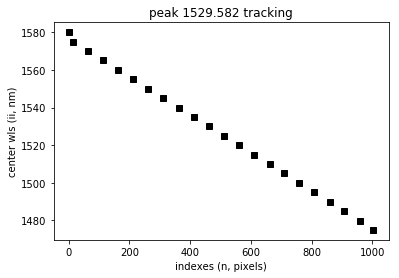

In [21]:
dispersion_data = []

for k,dispersion_initial_data_point in enumerate(dispersion_initial_data_points):
    
    ii, dispersion_data_k = dispersion_initial_data_point
        
    wl_actual, center_wl, n_peak = dispersion_data_k[0]

    dispersion_data_k = get_dispersion_data_backward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)
    dispersion_data_k = dispersion_data_k[::-1] #just for plotting convinience
    dispersion_data_k = get_dispersion_data_forward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)

    dispersion_data_k = clean_repetitions(dispersion_data_k);
    
    dispersion_data_k = np.array(dispersion_data_k)

    plt.figure()
    plt.plot(dispersion_data_k[:,2],dispersion_data_k[:,1],'ks')
    plt.title('peak {} tracking'.format(calibration_lines_wls[k]) )
    plt.ylabel('center wls (ii, nm)')
    plt.xlabel('indexes (n, pixels)')
    #plt.xlim(0,1024)

    dispersion_data.append(dispersion_data_k)
    
    
dispersion_data = np.concatenate(dispersion_data)

#### fit model with data

In [22]:
initial_guess = (f,0.1,0.1,0)

kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
print(initial_guess - result.x)
print(result.message, result.nfev)

res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
#print(Y)


print('########################### COPY FOLLOWING #############################')

print(str([ res_dict[x] for x in Y ]))

[  1.32245636e+08   1.09185198e+00  -3.71764203e-01   1.42064480e-05]
`xtol` termination condition is satisfied. 104
########################### COPY FOLLOWING #############################
[167754364.01367188, -0.99185198386544982, 0.47176420343679826, 466.5, 0, 1666.6666666666667, 25000.0, -1.4206447961573932e-05]


# grating (2, '600 g/mm BLZ=  1.2UM ')

In [23]:
###################################### INPUTS HERE ##########
fname  = 'grating_2_data/190116_163059_calibration_sweep.h5'
d_grating = 1e6/600 #nm /groove
px_offsets_data = [466]
calibration_lines_wls = [912.288, 
                         965.770, 
                         1013.975,
                         1128.71,
                         1529.582
                        ]

In [24]:
n0 = np.mean(px_offsets_data)
calibration_lines_wls = sorted(calibration_lines_wls)

### dispersion data

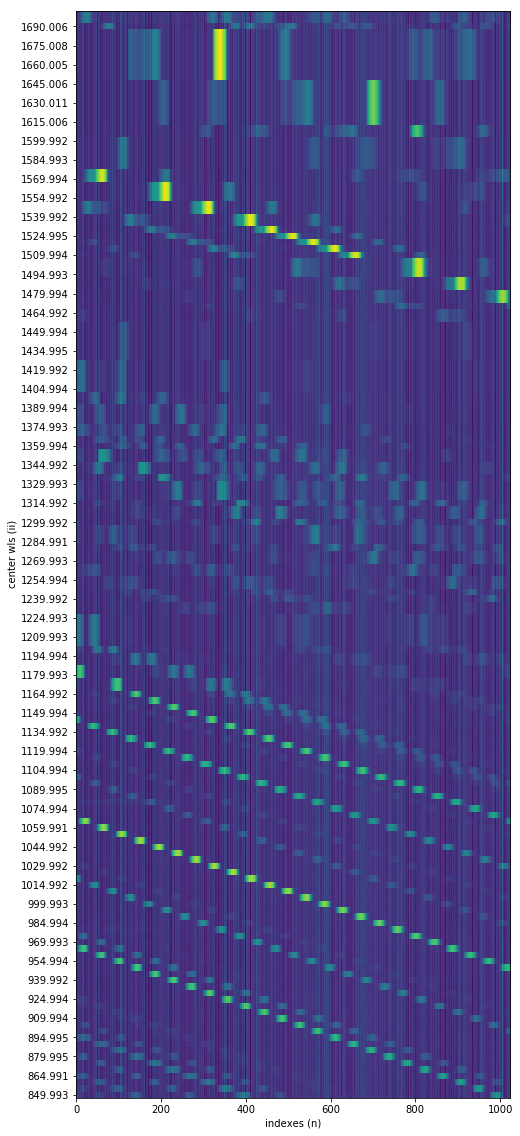

In [26]:
h5_file=h5py.File(fname)
center_wls=h5_file['measurement/calibration_sweep/center_wls'].value
spectra=h5_file['measurement/calibration_sweep/spectra'].value
h5_file.close()

plt.figure(figsize=(20,20))
plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(15)
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')
plt.yticks(arange_like(center_wls)[::3],center_wls[::3]);

### find peaks and identify calibration peaks based on center wls

[[12, [[912.288, 909.99400000000003, 483]]], [23, [[965.77, 964.99400000000003, 472]]], [33, [[1013.975, 1014.992, 457]]], [56, [[1128.71, 1129.991, 452]]], [136, [[1529.582, 1529.9939999999999, 460]]]]


(0, 1024)

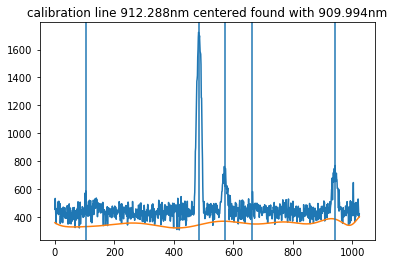

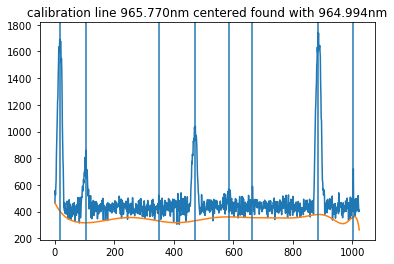

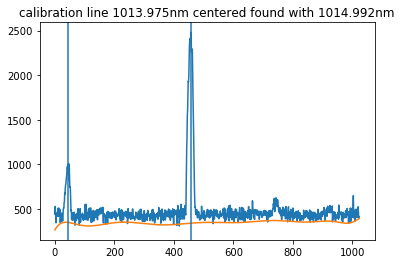

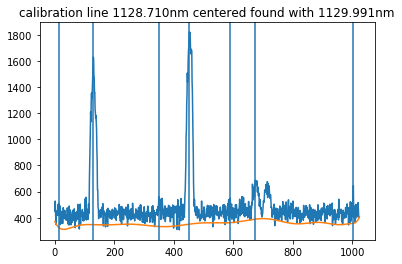

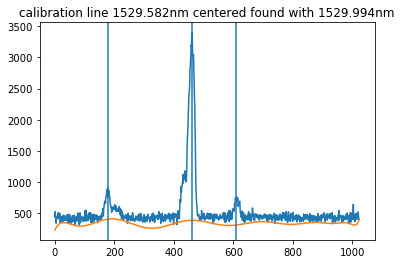

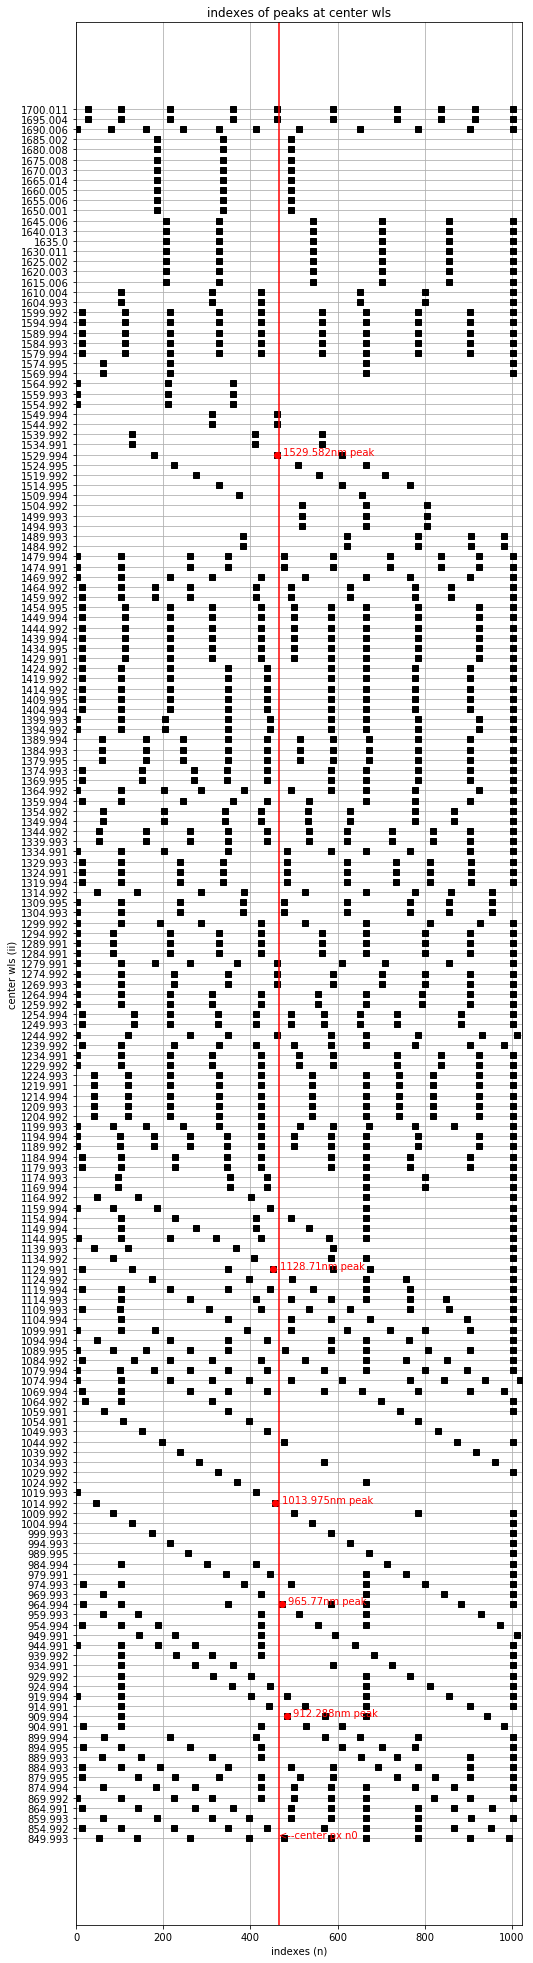

In [27]:
# find spectrum center wls is closest to calibration lines
ii_peak_identifyers = np.array([argmin(center_wls, wls) for wls in calibration_lines_wls])

plot_spectra = True
peak_indexes = []

jj = 0 
dispersion_initial_data_points = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 20)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
        
    if plot_spectra and ii in ii_peak_identifyers:
        calibration_line = calibration_lines_wls[jj]
        center_wl = center_wls[ii]
        plt.figure()
        plt.title('calibration line {:1.3f}nm centered found with {:1.3f}nm'.format(calibration_line, center_wl ) )
        
        n_peak = indexes[ argmin(indexes, n0) ]

        disp = [[calibration_line, center_wls[ii], n_peak]]
        dispersion_initial_data_points.append([ii, disp])
        
        jj += 1
                
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure(figsize=(8,35))
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
plt.title('indexes of peaks at center wls')
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')

plt.grid(True, which='both', ydata = arange_like(center_wls))

plt.yticks(arange_like(center_wls)[::1],center_wls[::1])

for k,(ii,dispersion_data) in enumerate(dispersion_initial_data_points):
    n_peak = dispersion_data[0][-1]
    plt.plot(n_peak,ii, 'or')
    plt.text(n_peak+15,ii, '{}nm peak'.format(calibration_lines_wls[k]), color='r')
    
print(dispersion_initial_data_points)

plt.axvline(n0, color='r')
plt.text(n0, 0, '<--center px n0', color='r')

plt.xlim(0,1024)
#plt.ylim(0,136)

### track individual peaks and associate with actual wavelengths

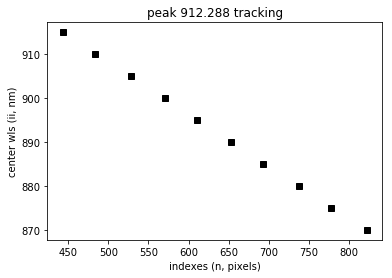

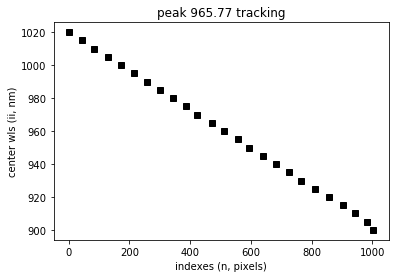

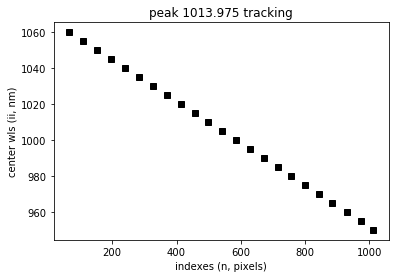

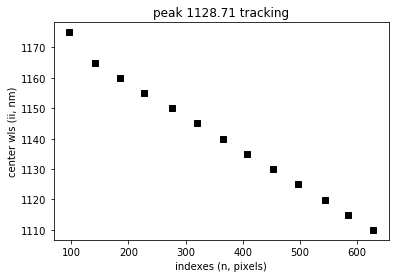

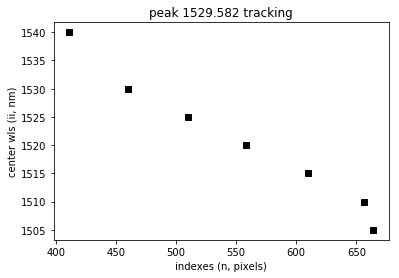

In [28]:
dispersion_data = []

for k,dispersion_initial_data_point in enumerate(dispersion_initial_data_points):
    
    ii, dispersion_data_k = dispersion_initial_data_point
        
    wl_actual, center_wl, n_peak = dispersion_data_k[0]

    dispersion_data_k = get_dispersion_data_backward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)
    dispersion_data_k = dispersion_data_k[::-1] #just for plotting convinience
    dispersion_data_k = get_dispersion_data_forward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)

    dispersion_data_k = clean_repetitions(dispersion_data_k);
    
    dispersion_data_k = np.array(dispersion_data_k)

    plt.figure()
    plt.plot(dispersion_data_k[:,2],dispersion_data_k[:,1],'ks')
    plt.title('peak {} tracking'.format(calibration_lines_wls[k]) )
    plt.ylabel('center wls (ii, nm)')
    plt.xlabel('indexes (n, pixels)')
    #plt.xlim(0,1024)

    dispersion_data.append(dispersion_data_k)
    
    
dispersion_data = np.concatenate(dispersion_data)

#### fit model with data

In [29]:
initial_guess = (f,1,0.1,0)

kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
#print(initial_guess - result.x)
#print(result.message, result.nfev)

res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
#print(Y)


print('########################### COPY FOLLOWING #############################')

print(str([ res_dict[x] for x in Y ]))

########################### COPY FOLLOWING #############################
[150910949.70703021, 1.1260144085439749, -0.22000770984149634, 466.0, 0, 1666.6666666666667, 25000.0, 1.9185758349986506e-05]


# grating (3, '400 g/mm BLZ=  1.2UM ')

### center wls and grating

In [31]:
fname = 'grating_3_data/190116_144255_calibration_sweep.h5'
d_grating = 1e6/300 #nm /groove
wl_center_data = [468.5, 469]
n0 = np.mean(wl_center_data)


calibration_lines_wls = [912.288, 
                         965.770, 
                         1013.975,
                         1128.71,
                         1529.582]
calibration_lines_wls = sorted(calibration_lines_wls)

### dispersion data

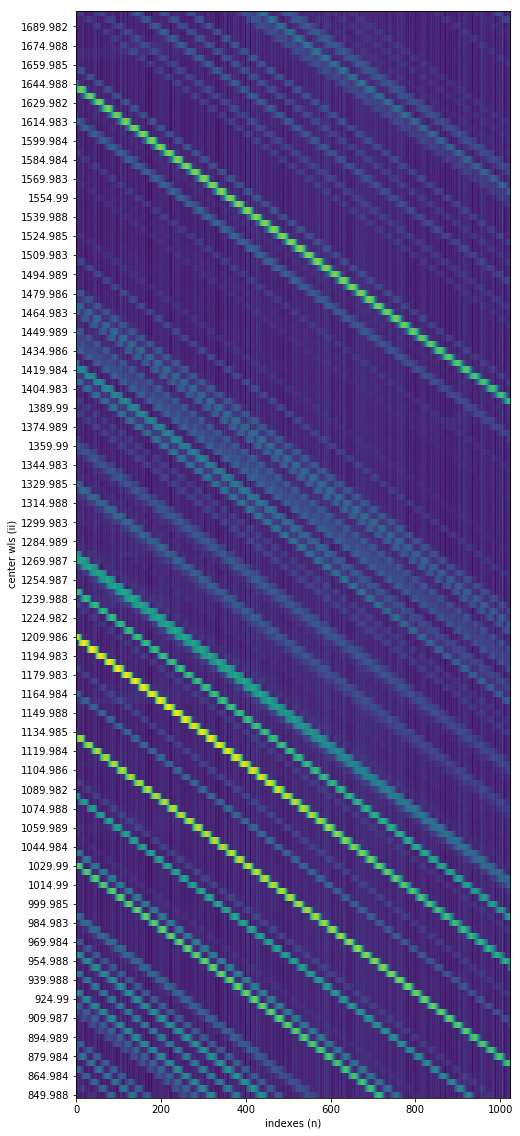

In [32]:
h5_file=h5py.File(fname)
center_wls=h5_file['measurement/calibration_sweep/center_wls'].value
spectra=h5_file['measurement/calibration_sweep/spectra'].value
h5_file.close()

plt.figure(figsize=(20,20))
plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(15)
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')
plt.yticks(arange_like(center_wls)[::3],center_wls[::3]);

### find peaks and identify calibration peaks based on center wls

[[12, [[912.288, 909.98699999999997, 478]]], [23, [[965.77, 964.98900000000003, 472]]], [33, [[1013.975, 1014.99, 464]]], [56, [[1128.71, 1129.9860000000001, 462]]], [136, [[1529.582, 1529.9870000000001, 466]]]]


(0, 1024)

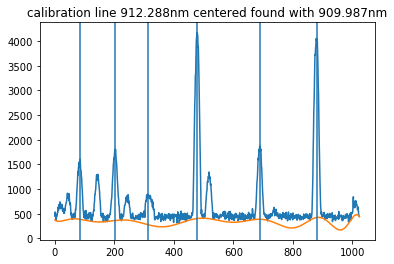

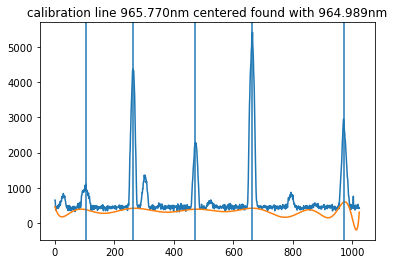

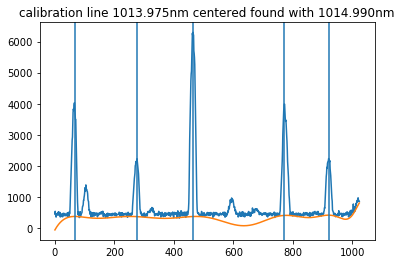

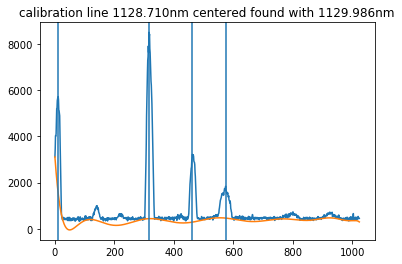

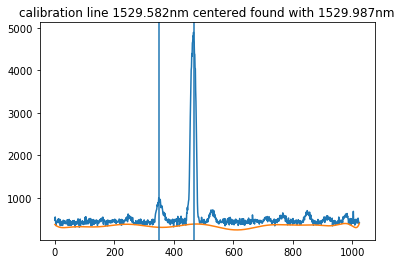

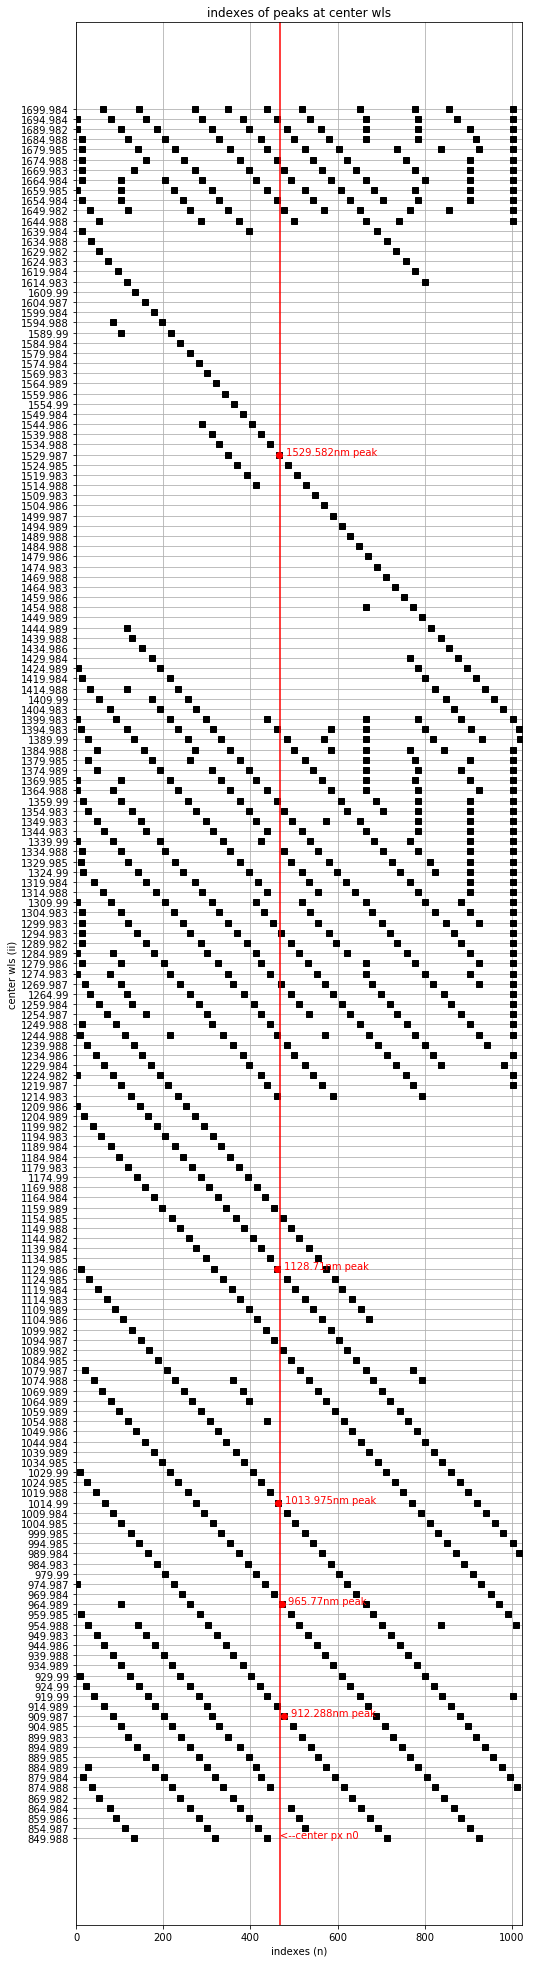

In [33]:
# find spectrum center wls is closest to calibration lines
ii_peak_identifyers = np.array([argmin(center_wls, wls) for wls in calibration_lines_wls])

plot_spectra = True
peak_indexes = []

jj = 0 
dispersion_initial_data_points = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 20)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
        
    if plot_spectra and ii in ii_peak_identifyers:
        calibration_line = calibration_lines_wls[jj]
        center_wl = center_wls[ii]
        plt.figure()
        plt.title('calibration line {:1.3f}nm centered found with {:1.3f}nm'.format(calibration_line, center_wl ) )
        
        n_peak = indexes[ argmin(indexes, n0) ]

        disp = [[calibration_line, center_wls[ii], n_peak]]
        dispersion_initial_data_points.append([ii, disp])
        
        jj += 1
                
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure(figsize=(8,35))
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
plt.title('indexes of peaks at center wls')
plt.ylabel('center wls (ii)')
plt.xlabel('indexes (n)')

plt.grid(True, which='both', ydata = arange_like(center_wls))

plt.yticks(arange_like(center_wls)[::1],center_wls[::1])

for k,(ii,dispersion_data) in enumerate(dispersion_initial_data_points):
    n_peak = dispersion_data[0][-1]
    plt.plot(n_peak,ii, 'or')
    plt.text(n_peak+15,ii, '{}nm peak'.format(calibration_lines_wls[k]), color='r')
    
print(dispersion_initial_data_points)

plt.axvline(n0, color='r')
plt.text(n0, 0, '<--center px n0', color='r')

plt.xlim(0,1024)
#plt.ylim(0,136)

### track individual peaks and associate with actual wavelengths

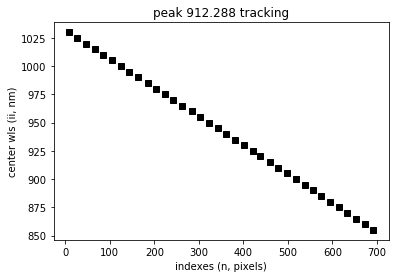

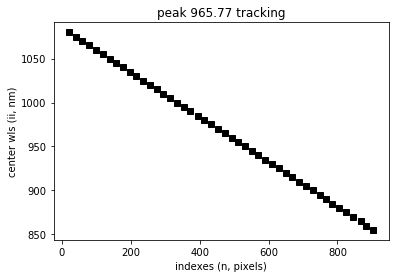

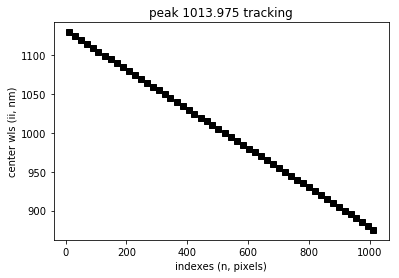

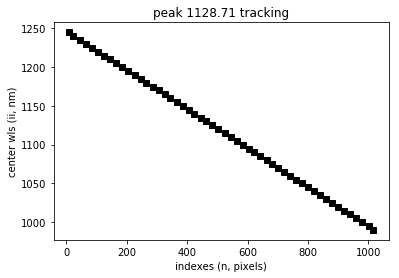

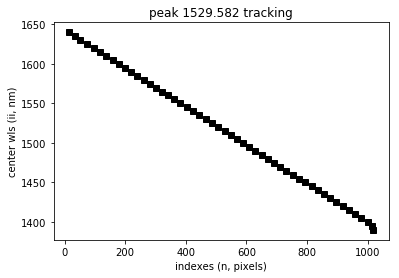

In [34]:
dispersion_data = []

for k,dispersion_initial_data_point in enumerate(dispersion_initial_data_points):
    
    ii, dispersion_data_k = dispersion_initial_data_point
        
    wl_actual, center_wl, n_peak = dispersion_data_k[0]

    dispersion_data_k = get_dispersion_data_backward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)
    dispersion_data_k = dispersion_data_k[::-1] #just for plotting convinience
    dispersion_data_k = get_dispersion_data_forward(ii, n_peak, wl_actual, center_wls, peak_indexes, dispersion_data_k)

    dispersion_data_k = clean_repetitions(dispersion_data_k);
    
    dispersion_data_k = np.array(dispersion_data_k)

    plt.figure()
    plt.plot(dispersion_data_k[:,2],dispersion_data_k[:,1],'ks')
    plt.title('peak {} tracking'.format(calibration_lines_wls[k]) )
    plt.ylabel('center wls (ii, nm)')
    plt.xlabel('indexes (n, pixels)')
    #plt.xlim(0,1024)

    dispersion_data.append(dispersion_data_k)
    
    
dispersion_data = np.concatenate(dispersion_data)

#### fit model with data

In [35]:
initial_guess = (f,0.1,0.1,0)

kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
#print(initial_guess - result.x)
#print(result.message, result.nfev)

res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
#print(Y)


print('########################### COPY FOLLOWING #############################')

print(str([ res_dict[x] for x in Y ]))

########################### COPY FOLLOWING #############################
[156168647.11046231, 1.026029303921079, 0.51668064532249247, 468.75, 0, 3333.3333333333335, 25000.0, 3.5816097110739938e-05]
